In [25]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pieman_utils import *


In [26]:
fmri_data = np.load('../data_pieman/fmri_data_pieman.npy')
print(fmri_data.shape)

data = fmri_data.copy()
data = np.swapaxes(data, 0,1)
data = np.swapaxes(data, 1,2)
print(data.shape)

(68, 300, 293)
(300, 293, 68)


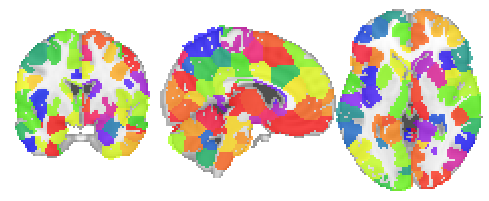

In [27]:
shen_file       = '../data_pieman/shen_2mm_268_parcellation.nii'

nilearn.plotting.plot_roi(shen_file, 
                  annotate = False, 
                  cut_coords = (5,0,0),
                  cmap = 'prism',
                  draw_cross = False, 
                  #title= 'Shen-268-node parcellation',
                 );
shen_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_file);

sample_file = '../data_pieman/func.nii'
shen_masker.fit_transform(sample_file);

In [28]:
ISC = pieman_isc(data, pairwise=True, summary_statistic = np.mean, verbose=False)
ISC.shape

ISC[np.isnan(ISC)] = 0

#alpha = .05
# Get q-values (i.e., FDR-controlled p-values) using statsmodels
#q = multipletests(p[0, :], method='fdr_by')[1]
#corrected = q[np.newaxis, :] < alpha
#ISC[corrected == False] = 0


/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


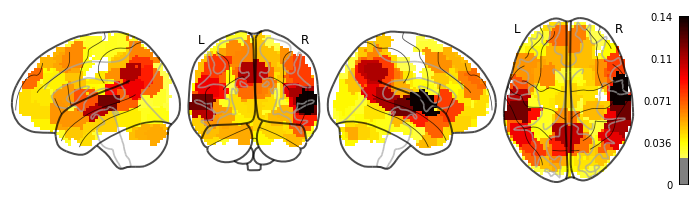

In [30]:
res_img = shen_masker.inverse_transform(ISC[:268]);

plotting.plot_glass_brain( nilearn.image.index_img(res_img,0) ,
                          display_mode = 'lyrz',
                          colorbar = 'True',
                         );

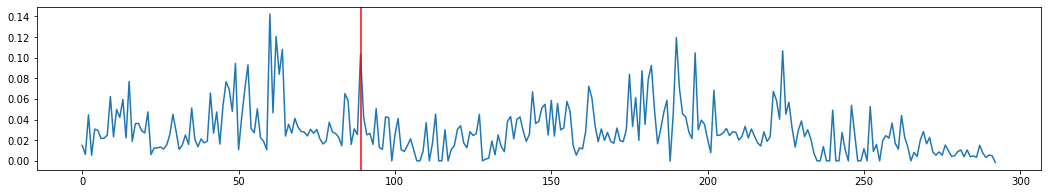

In [8]:
plt.figure(figsize = (18,3))
plt.plot(ISC.T);
plt.axvline(89, color = 'red')

0.6331274221665713


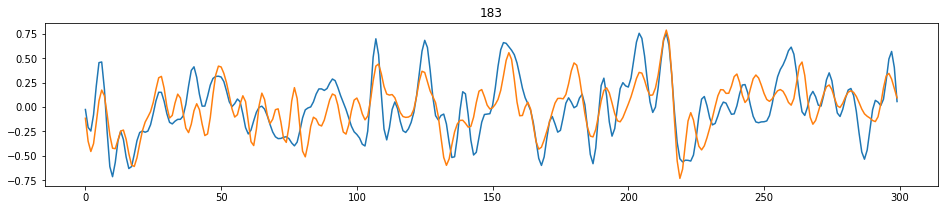

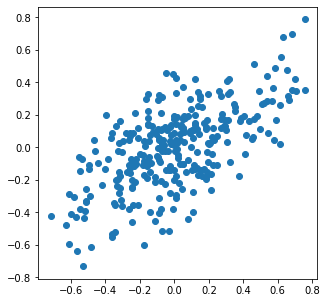

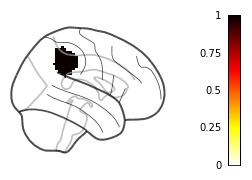

In [33]:
m1 = np.mean(data[:,:, :34], axis =2)
m2 = np.mean(data[:,:, 34:], axis =2)

curr_roi = 183

plt.figure(figsize = (16,3))

plt.plot(m1[:,curr_roi]);
plt.plot(m2[:,curr_roi]);
plt.title(str(curr_roi))
print(np.corrcoef(m1[:,curr_roi], m2[:,curr_roi])[0,1])

plt.figure(figsize = (5,5))
plt.scatter(m1[:,curr_roi],
           m2[:,curr_roi])

roi_vec = np.zeros((1,268))
roi_vec[0,curr_roi] = 1
roi_img = shen_masker.inverse_transform(roi_vec);
plotting.plot_glass_brain( nilearn.image.index_img(roi_img,0) ,
                          display_mode = 'x',
                          colorbar = 'True',
                         ) #'''

In [10]:
#Pauli
subcortex = nilearn.datasets.fetch_atlas_pauli_2017()
pauli_masker = input_data.NiftiMapsMasker(subcortex.maps[2]);
sample_file = '../data_pieman/func.nii'
#pauli_masker.fit_transform(sample_file);

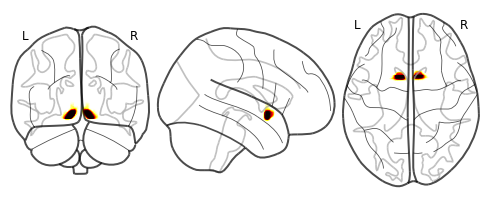

In [11]:
plotting.plot_glass_brain(nilearn.image.index_img(subcortex.maps, 2))